In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, Lasso
from scipy import stats
import pandas as pd
from sklearn.model_selection import KFold

In [3]:
#adatok beolvasása 
def file_open(path):
    with open(path, encoding="UTF-8") as f:
        x = f.readlines()
    del x[0]
    return x

def yesno_dummy(v):
    return 1 if v=="yes" else 0

def harom_dummy(v):
    if v=="furnished":
        v=(1,1)
    elif v=="semi-furnished":
        v=(1,0)
    else:
        v=(0,1)
    return v

def data_management(raw_data):
    y = []
    x1 = []
    x2 = []
    x3 = []
    x4 = []
    x5 = []
    x6 = []
    x7 = []
    x8 = []
    for line in raw_data:
        variables = line.strip().split(",")
        y.append(int(variables[0]))               # price
        x1.append(int(variables[1]))              # area
        x2.append(int(variables[2]))              # bedrooms
        x3.append(int(variables[3]))              # bathrooms
        x4.append(int(variables[4]))              # stories
        x5.append(yesno_dummy(variables[5]))      # mainroad
        x6.append(yesno_dummy(variables[6]))      # guestroom
        x7.append(yesno_dummy(variables[7]))      # basement
        x8.append(int(variables[10]))     # parking
    return y, x1, x2, x3, x4, x5, x6, x7, x8

raw_data = file_open("Housing.csv")



#print(variables)


In [4]:
def rmse(actual, predicted):
    actual = np.asarray(actual)
    predicted = np.asarray(predicted)
    return float(np.sqrt(np.mean((actual - predicted)**2)))

def create_design_matrix(data_x_df, var_list):
    X = data_x_df[var_list].values
    
    X_with_const = np.hstack([np.ones((X.shape[0], 1)), X])
    return X_with_const

def fit_multivar(data_df, var_list):
    X = create_design_matrix(data_df, var_list)
    y = data_df["y"].values
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    
    # A modell most az együtthatókból ÉS a felhasznált változók listájából áll
    return {"beta": beta, "variables": var_list}

def predict_multivar(model, x_new_df):
    var_list = model["variables"]
    Xn = create_design_matrix(x_new_df, var_list)
    return Xn @ model["beta"]

def make_splits(dat, p_tr=0.64, p_va=0.16, seed=3):
    rng = np.random.default_rng(seed)
    n = len(dat)
    idx = rng.permutation(n)
    ntr = int(np.floor(p_tr * n))
    nva = int(np.floor(p_va * n))
    tr = dat.iloc[idx[:ntr]].reset_index(drop=True)
    va = dat.iloc[idx[ntr:ntr+nva]].reset_index(drop=True)
    te = dat.iloc[idx[ntr+nva:]].reset_index(drop=True)
    return {"train": tr, "valid": va, "test": te}

def fit_ols_with_ic(df, cols):
    X = df[cols].values
    y = df["y"].values
    Xc = sm.add_constant(X)  # intercept, mint az R-ben
    res = sm.OLS(y, Xc).fit()
    return res.aic, res.bic


In [5]:
raw_data = file_open("Housing.csv")
variables = data_management(raw_data)
y, x1, x2, x3, x4, x5, x6, x7, x8 = variables

df = pd.DataFrame({
    'y': y,     
    'x1': x1,   # area
    'x2': x2,   # bedrooms
    'x3': x3,   # bathrooms
    'x4': x4,   # stories
    'x5': x5,   # mainroad
    'x6': x6,   # guestroom
    'x7': x7,   # basement
    'x8': x8    # furnishingstatus
})

splits = make_splits(df, p_tr=0.64, p_va=0.16, seed=3)

In [6]:
all_vars = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
model_definitions = []
for i in range(1, 9):
    model_definitions.append(all_vars[:i])

print("\n--- Modell definíciók (komplexitás) ---")
for md in model_definitions:
    print(f"  - Modell {len(md)} változóval: {md}")  
    
models = {}
    


--- Modell definíciók (komplexitás) ---
  - Modell 1 változóval: ['x1']
  - Modell 2 változóval: ['x1', 'x2']
  - Modell 3 változóval: ['x1', 'x2', 'x3']
  - Modell 4 változóval: ['x1', 'x2', 'x3', 'x4']
  - Modell 5 változóval: ['x1', 'x2', 'x3', 'x4', 'x5']
  - Modell 6 változóval: ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
  - Modell 7 változóval: ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7']
  - Modell 8 változóval: ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']


In [15]:
# Direkt módszer szimuláció
n_sims = 100
rmse_tr_mat = np.full((n_sims, len(model_definitions)), np.nan, dtype=float)
rmse_va_mat = np.full((n_sims, len(model_definitions)), np.nan, dtype=float)
holdout_rmse = np.full(n_sims, np.nan)

n_mods= len(model_definitions)
AIC_mat = np.full((n_sims, n_mods), np.nan, dtype=float)
BIC_mat = np.full((n_sims, n_mods), np.nan, dtype=float)
aic_pick = np.zeros(n_sims, dtype=int)
bic_pick = np.zeros(n_sims, dtype=int)

rmse_lasso_manual = np.full(n_sims, np.nan)
best_alphas = np.full(n_sims, np.nan) # Kíváncsiságból eltároljuk, miket választott
avg_features_num = np.full(n_sims, np.nan) # Hány változót tartott meg
alphas_to_try = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0]

rng_master = np.random.default_rng(3)

raw_data = file_open("Housing.csv")
variables = data_management(raw_data)
y, x1, x2, x3, x4, x5, x6, x7, x8 = variables

df = pd.DataFrame({
    'y': y,     
    'x1': x1,   # area
    'x2': x2,   # bedrooms
    'x3': x3,   # bathrooms
    'x4': x4,   # stories
    'x5': x5,   # mainroad
    'x6': x6,   # guestroom
    'x7': x7,   # basement
    'x8': x8    # parking
})

for s in range(n_sims):
    idx = np.arange(len(df))
    rng_split = np.random.default_rng(int(rng_master.integers(0, 1_000_000)))
    rng_split.shuffle(idx)
    trnval_idx = idx[: int(np.floor(0.8 * len(df)))]
    test_idx   = idx[int(np.floor(0.8 * len(df))):]

    trnval = df.iloc[trnval_idx].reset_index(drop=True)
    test   = df.iloc[test_idx].reset_index(drop=True)
    
    idx2 = np.arange(len(trnval))
    rng_split2 = np.random.default_rng(int(rng_master.integers(0, 1_000_000)))
    rng_split2.shuffle(idx2)
    trn_idx = idx2[: int(np.floor(0.8 * len(trnval)))]
    val_idx = idx2[int(np.floor(0.8 * len(trnval))):]

    trn = trnval.iloc[trn_idx].reset_index(drop=True)
    val = trnval.iloc[val_idx].reset_index(drop=True)
    
    current_val_rmse = []
    
    for j, ix in enumerate(model_definitions):
        # JAVÍTÁS: 'variables' helyett 'ix'-et kell átadni (az oszlopnevek listáját)
        model = fit_multivar(trn, ix) 

        # Train RMSE
        pred_tr = predict_multivar(model, trn)
        rmse_tr_mat[s, j] = rmse(trn["y"], pred_tr)

        # Valid RMSE
        pred_va = predict_multivar(model, val)
        rmse_val_value = rmse(val["y"], pred_va)
        
        rmse_va_mat[s, j] = rmse_val_value
        current_val_rmse.append(rmse_val_value)
        
    # illesztés és IC-k számítása trnval-on
    aic_vals = np.empty(n_mods, dtype=float)
    bic_vals = np.empty(n_mods, dtype=float)
    for j, variables in enumerate(model_definitions):
        model = fit_multivar(trnval, variables)
        y_pred = predict_multivar(model, trnval)
        n = len(trnval)
        k = len(variables) + 1       
        resid = trnval["y"] - y_pred
        rss = np.sum(resid**2)
        aic = n * np.log(rss/n) + 2*k
        bic = n * np.log(rss/n) + k * np.log(n)
        aic_vals[j] = aic
        bic_vals[j] = bic
    
    AIC_mat[s, :] = aic_vals
    BIC_mat[s, :] = bic_vals
    aic_pick[s] = int(np.argmin(aic_vals)) + 1  # model_id (1-indexelt)
    bic_pick[s] = int(np.argmin(bic_vals)) + 1
    
    # 2. Adatok előkészítése (SKÁLÁZÁS)
    # Minden változót használunk (x1-től x8-ig)
    feature_cols = [f"x{i}" for i in range(1, 9)]
    
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    # Fit csak a belső TRAIN halmazon!
    X_train_sc = scaler_X.fit_transform(trn[feature_cols])
    y_train_sc = scaler_y.fit_transform(trn[['y']]).flatten()
    
    X_valid_sc = scaler_X.transform(val[feature_cols])
    # Y validáláshoz nem kell skálázni a predikcióhoz, de az RMSE számításhoz majd vissza kell transzformálni a becslést.
    
    # 3. Alpha (Lambda) kiválasztása a Validation RMSE alapján
    best_alpha = None
    best_val_rmse = float('inf')
    
    for alpha in alphas_to_try:
        # Modell illesztése
        lasso = Lasso(alpha=alpha, max_iter=10000, random_state=1)
        lasso.fit(X_train_sc, y_train_sc)
        
        # Predikció a validációs halmazon (skálázott térben)
        pred_val_sc = lasso.predict(X_valid_sc)
        
        # Visszaskálázás eredeti árakra
        pred_val = scaler_y.inverse_transform(pred_val_sc.reshape(-1, 1)).flatten()
        
        # Hiba számítása
        current_rmse = rmse(val['y'], pred_val)
        
        if current_rmse < best_val_rmse:
            best_val_rmse = current_rmse
            best_alpha = alpha
            
    best_alphas[s] = best_alpha
    
    # 4. Újraillesztés (Refit) a teljes WORK (TrnVal) halmazon a nyertes alphával
    # Újra kell fit-elni a skálázót a teljes work halmazon!
    X_work_sc = scaler_X.fit_transform(trnval[feature_cols])
    y_work_sc = scaler_y.fit_transform(trnval[['y']]).flatten()
    X_test_sc = scaler_X.transform(test[feature_cols])


In [10]:
#Lasso CV
n_sims = 100
rng_master = np.random.default_rng(2)

rmse_LASSO = np.empty(n_sims)
rmse_VALSEL = np.empty(n_sims)


pick_val = np.empty(n_sims, dtype=int)
lasso_df = np.empty(n_sims, dtype=int)

alphas_to_try = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0]

rng_master = np.random.default_rng(3)

for s in range(n_sims):
    idx = np.arange(len(df))
    rng_split = np.random.default_rng(int(rng_master.integers(0, 1_000_000)))
    rng_split.shuffle(idx)
    trnval_idx = idx[: int(np.floor(0.8 * len(df)))]
    test_idx   = idx[int(np.floor(0.8 * len(df))):]

    trnval = df.iloc[trnval_idx].reset_index(drop=True)
    test   = df.iloc[test_idx].reset_index(drop=True)
    
    #LassoCV
    all_features = [f"x{i}" for i in range(1, 9)]
    X_tv = trnval[all_features].values
    y_tv = trnval["y"].values
    X_te = test[all_features].values
    
    lcv = make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        LassoCV(cv=5, random_state=int(rng_master.integers(0, 1_000_000)), n_alphas=100)
    )
    lcv.fit(X_tv, y_tv)
    
    # Lasso predikció a teszt halmazon
    yhat_lasso = lcv.predict(X_te)
    rmse_LASSO[s] = rmse(test["y"], yhat_lasso)
    
    # Hány változót tartott meg?
    coef = lcv.named_steps["lassocv"].coef_
    lasso_df[s] = int((np.abs(coef) > 1e-12).sum())
    
    idx2 = np.arange(len(trnval))
    rng_split2 = np.random.default_rng(int(rng_master.integers(0, 1_000_000)))
    rng_split2.shuffle(idx2)
    trn_idx = idx2[: int(np.floor(0.8 * len(trnval)))]
    val_idx = idx2[int(np.floor(0.8 * len(trnval))):]
    scaler_X = StandardScaler()
    scaler_y = StandardScaler() 
    
    
    # Itt NEM csinálunk belső fix vágást (trn/val), helyette K-Fold-ot készítünk elő
    kf = KFold(n_splits=5, shuffle=True, random_state=int(rng_master.integers(0, 1_000_000)))
    
    current_sim_cv_rmses = [] # Ebben tároljuk a 8 modell átlagos CV hibáját
    
    # Minden modellt kiértékelünk 5-fold CV-vel
    for j, ix in enumerate(model_definitions):
        fold_rmses = []
        
        # Végigmegyünk az 5 hajtáson
        for train_index, val_index in kf.split(trnval):
            # K-Fold indexelés
            fold_train = trnval.iloc[train_index]
            fold_valid = trnval.iloc[val_index]
            
            # Illesztés a fold train részén
            model = fit_multivar(fold_train, ix)
            
            # Predikció a fold valid részén
            pred_fold = predict_multivar(model, fold_valid)
            fold_err = rmse(fold_valid["y"], pred_fold)
            fold_rmses.append(fold_err)
        
        # Átlagos hiba a modellszelekcióhoz
        avg_cv_rmse = np.mean(fold_rmses)
        
        # Eredmények mentése
        rmse_cv_mat[s, j] = avg_cv_rmse
        current_sim_cv_rmses.append(avg_cv_rmse)




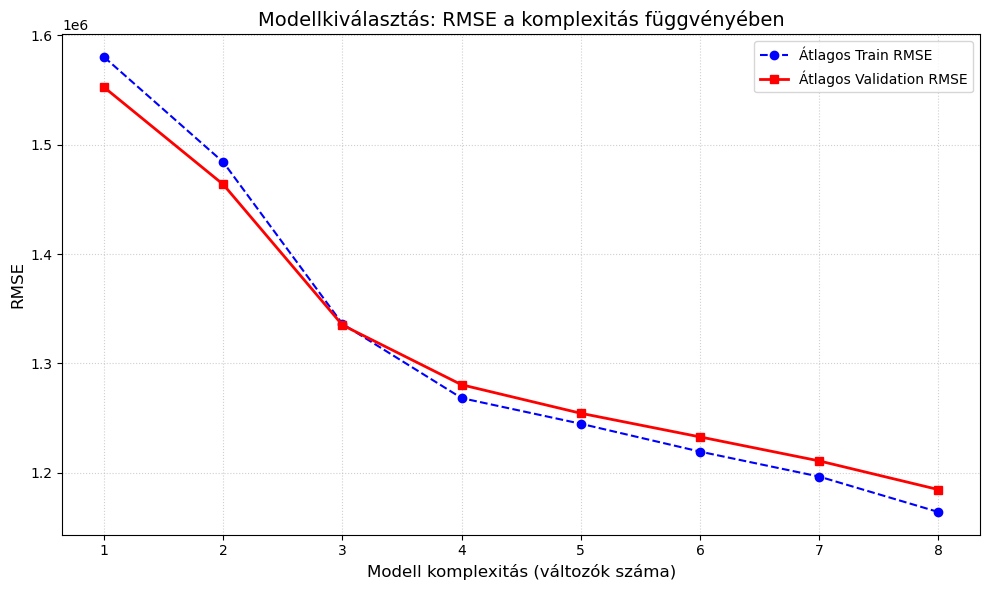

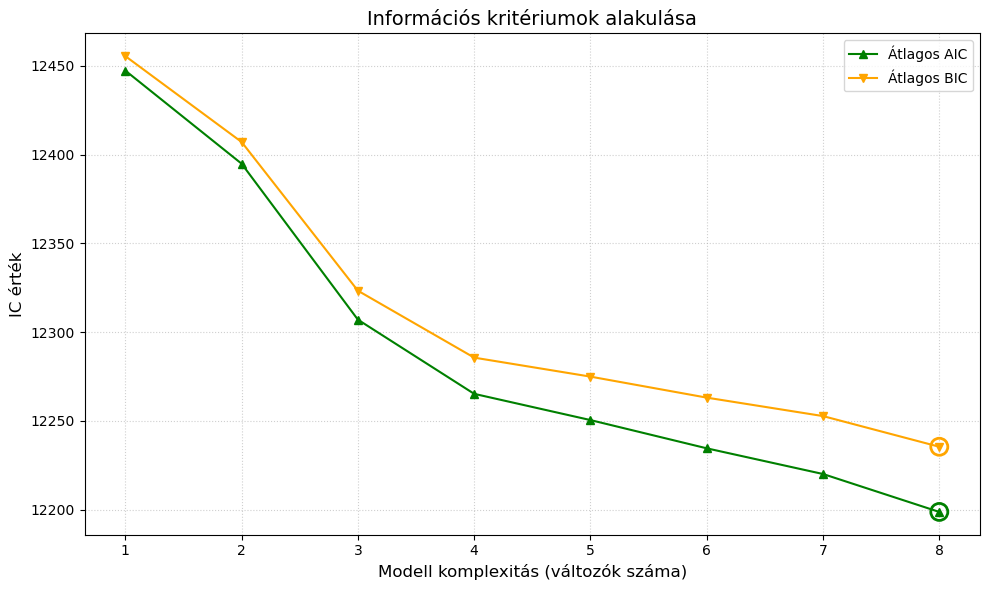

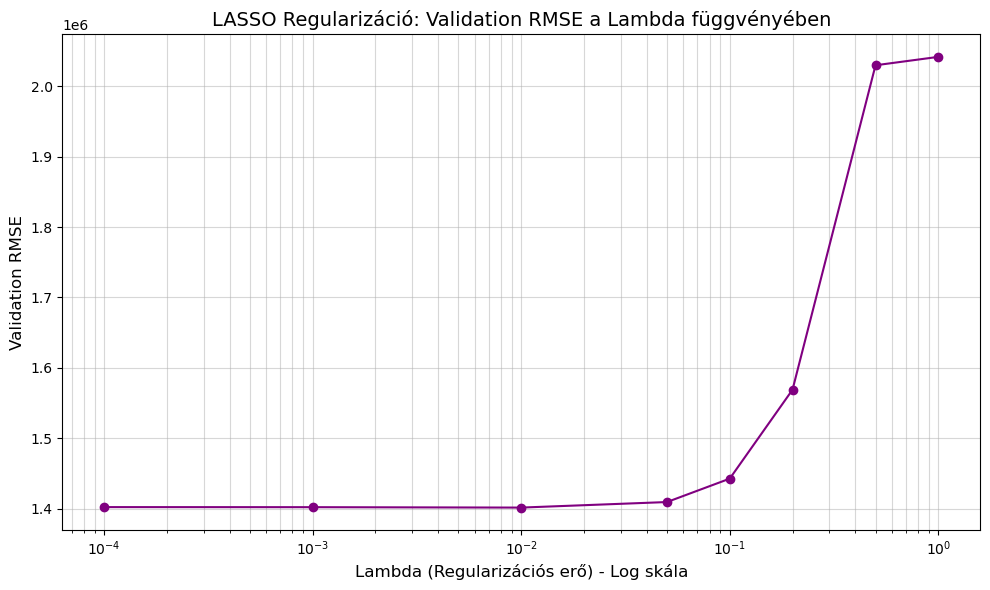

In [16]:

# -----------------------------------------------------------
# 1. ÁBRA: RMSE vs. Modellindex (Direkt módszer)
# -----------------------------------------------------------
# Átlagok számítása a 100 futtatásból (oszloponként)
mean_rmse_tr = np.nanmean(rmse_tr_mat, axis=0)
mean_rmse_va = np.nanmean(rmse_va_mat, axis=0)
model_indices = np.arange(1, 9)  # 1-től 8-ig

plt.figure(figsize=(10, 6))
plt.plot(model_indices, mean_rmse_tr, marker='o', label='Átlagos Train RMSE', color='blue', linestyle='--')
plt.plot(model_indices, mean_rmse_va, marker='s', label='Átlagos Validation RMSE', color='red', linewidth=2)

plt.title('Modellkiválasztás: RMSE a komplexitás függvényében', fontsize=14)
plt.xlabel('Modell komplexitás (változók száma)', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.xticks(model_indices)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 2. ÁBRA: AIC és BIC vs. Modellindex (Indirekt módszer)
# -----------------------------------------------------------
# Átlagok számítása
mean_aic = np.nanmean(AIC_mat, axis=0)
mean_bic = np.nanmean(BIC_mat, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(model_indices, mean_aic, marker='^', label='Átlagos AIC', color='green')
plt.plot(model_indices, mean_bic, marker='v', label='Átlagos BIC', color='orange')

# Jelöljük meg a minimumokat
min_aic_idx = np.argmin(mean_aic)
min_bic_idx = np.argmin(mean_bic)

plt.scatter(min_aic_idx + 1, mean_aic[min_aic_idx], s=150, facecolors='none', edgecolors='green', linewidth=2, zorder=5)
plt.scatter(min_bic_idx + 1, mean_bic[min_bic_idx], s=150, facecolors='none', edgecolors='orange', linewidth=2, zorder=5)

plt.title('Információs kritériumok alakulása', fontsize=14)
plt.xlabel('Modell komplexitás (változók száma)', fontsize=12)
plt.ylabel('IC érték', fontsize=12)
plt.xticks(model_indices)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------------------------------------
# 3. ÁBRA: LASSO kiválasztási görbe (RMSE vs Lambda)
# -----------------------------------------------------------
# Megjegyzés: Ehhez le kell futtatni egy reprezentatív LASSO illesztést, 
# hogy kinyerjük a görbét (mivel a szimulációban nem mentettük el az összes pontot).

# Adatok előkészítése egyetlen futtatáshoz (pl. az utolsó 's' index alapján)
# Feltételezzük, hogy a 'trn' és 'val' változók még elérhetők az utolsó ciklusból, 
# vagy újra generáljuk őket:
features = [f"x{i}" for i in range(1, 9)]
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_sc = scaler_X.fit_transform(trn[features])
y_train_sc = scaler_y.fit_transform(trn[['y']]).flatten()
X_valid_sc = scaler_X.transform(val[features])

# Lambda értékek (Alphas)
alphas_for_plot = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0]
lasso_rmses = []

for alpha in alphas_for_plot:
    l = Lasso(alpha=alpha, max_iter=10000, random_state=42)
    l.fit(X_train_sc, y_train_sc)
    
    # Predikció és visszaskálázás
    pred_sc = l.predict(X_valid_sc)
    pred = scaler_y.inverse_transform(pred_sc.reshape(-1,1)).flatten()
    
    lasso_rmses.append(rmse(val['y'], pred))

# Ábrázolás
plt.figure(figsize=(10, 6))
plt.plot(alphas_for_plot, lasso_rmses, marker='o', color='purple')
plt.xscale('log')  # Logaritmikus skála a lambdának (szokásos ábrázolás)

plt.title('LASSO Regularizáció: Validation RMSE a Lambda függvényében', fontsize=14)
plt.xlabel('Lambda (Regularizációs erő) - Log skála', fontsize=12)
plt.ylabel('Validation RMSE', fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.tight_layout()
plt.show()

In [18]:
# --- TELJES SZIMULÁCIÓ ÉS TÁBLÁZAT GENERÁLÁS ---
import pandas as pd

n_sims = 100
rng = np.random.default_rng(42)

# Tárolók az eredményeknek
rmse_tr_mat = np.full((n_sims, 8), np.nan)
rmse_va_mat = np.full((n_sims, 8), np.nan)
AIC_mat = np.full((n_sims, 8), np.nan)
BIC_mat = np.full((n_sims, 8), np.nan)

# Holdout RMSE tároló minden módszerre
holdout_results = {
    "Direkt (Valid RMSE)": np.empty(n_sims),
    "Indirekt (AIC)": np.empty(n_sims),
    "Indirekt (BIC)": np.empty(n_sims),
    "LASSO CV": np.empty(n_sims)
}

print(f"Szimuláció futtatása {n_sims} ismétléssel...")

for s in range(n_sims):
    # 1. Adatfelosztás (Work / Holdout)
    idx = np.arange(len(df))
    rng.shuffle(idx)
    work = df.iloc[idx[:int(0.8*len(df))]].reset_index(drop=True)
    test = df.iloc[idx[int(0.8*len(df)):]].reset_index(drop=True)
    
    # Belső felosztás (Train / Valid) a Direkt módszerhez
    idx2 = np.arange(len(work))
    rng.shuffle(idx2)
    trn = work.iloc[idx2[:int(0.8*len(work))]].reset_index(drop=True)
    val = work.iloc[idx2[int(0.8*len(work)):]].reset_index(drop=True)
    
    # --- MODELL ILLESZTÉSEK (1-8 változó) ---
    current_val_rmses = []
    current_aics = []
    current_bics = []
    
    for j, cols in enumerate(model_definitions):
        # Direkt módszer (Train fit -> Valid eval)
        mod_tr = fit_multivar(trn, cols)
        pred_tr = predict_multivar(mod_tr, trn)
        pred_va = predict_multivar(mod_tr, val)
        
        rmse_tr_mat[s, j] = rmse(trn["y"], pred_tr)
        val_err = rmse(val["y"], pred_va)
        rmse_va_mat[s, j] = val_err
        current_val_rmses.append(val_err)
        
        # Indirekt módszer (Work fit -> AIC/BIC)
        # Itt statsmodels-t használunk az IC kinyeréséhez
        X_work = sm.add_constant(work[cols].values)
        res = sm.OLS(work["y"], X_work).fit()
        AIC_mat[s, j] = res.aic
        BIC_mat[s, j] = res.bic
        current_aics.append(res.aic)
        current_bics.append(res.bic)
        
    # --- KIVÁLASZTÁS ÉS HOLDOUT TESZT ---
    
    # 1. Direkt (Min Valid RMSE) -> Refit on Work -> Predict Test
    best_idx_direkt = np.argmin(current_val_rmses)
    mod_direkt = fit_multivar(work, model_definitions[best_idx_direkt])
    holdout_results["Direkt (Valid RMSE)"][s] = rmse(test["y"], predict_multivar(mod_direkt, test))
    
    # 2. AIC -> Refit on Work (már megvan a definíció) -> Predict Test
    best_idx_aic = np.argmin(current_aics)
    mod_aic = fit_multivar(work, model_definitions[best_idx_aic])
    holdout_results["Indirekt (AIC)"][s] = rmse(test["y"], predict_multivar(mod_aic, test))
    
    # 3. BIC -> Refit on Work -> Predict Test
    best_idx_bic = np.argmin(current_bics)
    mod_bic = fit_multivar(work, model_definitions[best_idx_bic])
    holdout_results["Indirekt (BIC)"][s] = rmse(test["y"], predict_multivar(mod_bic, test))
    
    # 4. LASSO CV
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_work_sc = scaler_X.fit_transform(work[all_vars])
    y_work_sc = scaler_y.fit_transform(work[['y']]).flatten()
    X_test_sc = scaler_X.transform(test[all_vars])
    
    # LassoCV automatikusan 5-fold CV-t csinál
    lcv = LassoCV(cv=5, random_state=int(rng.integers(0, 1e6)), n_alphas=100).fit(X_work_sc, y_work_sc)
    pred_lasso_sc = lcv.predict(X_test_sc)
    pred_lasso = scaler_y.inverse_transform(pred_lasso_sc.reshape(-1,1)).flatten()
    holdout_results["LASSO CV"][s] = rmse(test["y"], pred_lasso)

# --- EREDMÉNY TÁBLÁZATOK ---

# 1. Táblázat: Train/Val RMSE per modell (Átlagok)
df_rmse_table = pd.DataFrame({
    "Változók száma": range(1, 9),
    "Átlagos Train RMSE": np.mean(rmse_tr_mat, axis=0),
    "Átlagos Valid RMSE": np.mean(rmse_va_mat, axis=0)
}).round(0)

# 2. Táblázat: AIC/BIC rangsorok (Átlagok)
df_ic_table = pd.DataFrame({
    "Változók száma": range(1, 9),
    "Átlagos AIC": np.mean(AIC_mat, axis=0),
    "Átlagos BIC": np.mean(BIC_mat, axis=0)
}).round(1)

# 3. Táblázat: Holdout Eredmények (Átlag +/- Szórás)
stats_list = []
for method, values in holdout_results.items():
    avg = np.mean(values)
    std = np.std(values)
    stats_list.append({
        "Módszer": method,
        "Holdout RMSE (Átlag)": avg,
        "Holdout RMSE (Szórás)": std,
        "Eredmény": f"{avg:.0f} ± {std:.0f}"
    })
df_holdout_table = pd.DataFrame(stats_list)

print("\n--- 1. TÁBLÁZAT: Train/Validation Hiba ---")
display(df_rmse_table)
print("\n--- 2. TÁBLÁZAT: Információs Kritériumok ---")
display(df_ic_table)
print("\n--- 3. TÁBLÁZAT: Végső Holdout Teljesítmény ---")
display(df_holdout_table)

Szimuláció futtatása 100 ismétléssel...

--- 1. TÁBLÁZAT: Train/Validation Hiba ---


,Változók száma,Átlagos Train RMSE,Átlagos Valid RMSE
0,1,1564364.0,1600625.0
1,2,1467601.0,1511636.0
2,3,1326528.0,1365055.0
3,4,1261891.0,1301894.0
4,5,1237693.0,1275913.0
5,6,1211439.0,1254864.0
6,7,1188427.0,1236402.0
7,8,1157364.0,1208373.0



--- 2. TÁBLÁZAT: Információs Kritériumok ---


,Változók száma,Átlagos AIC,Átlagos BIC
0,1,13683.3,13691.4
1,2,13630.5,13642.7
2,3,13543.6,13559.9
3,4,13502.4,13522.8
4,5,13487.4,13511.9
5,6,13471.4,13500.0
6,7,13457.3,13489.9
7,8,13436.6,13473.3



--- 3. TÁBLÁZAT: Végső Holdout Teljesítmény ---


,Módszer,Holdout RMSE (Átlag),Holdout RMSE (Szórás),Eredmény
0,Direkt (Valid RMSE),1.202328e+06,126065.563041,1202328 ± 126066
1,Indirekt (AIC),1.189121e+06,118683.908224,1189121 ± 118684
2,Indirekt (BIC),1.189121e+06,118683.908224,1189121 ± 118684
3,LASSO CV,1.189363e+06,119281.925318,1189363 ± 119282


Szimuláció futtatása 100 ismétléssel az eloszlás ábrákhoz...


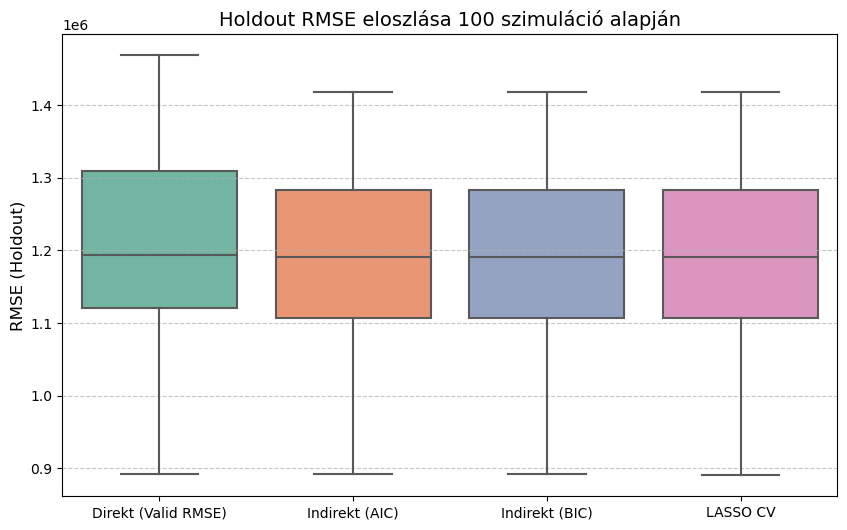

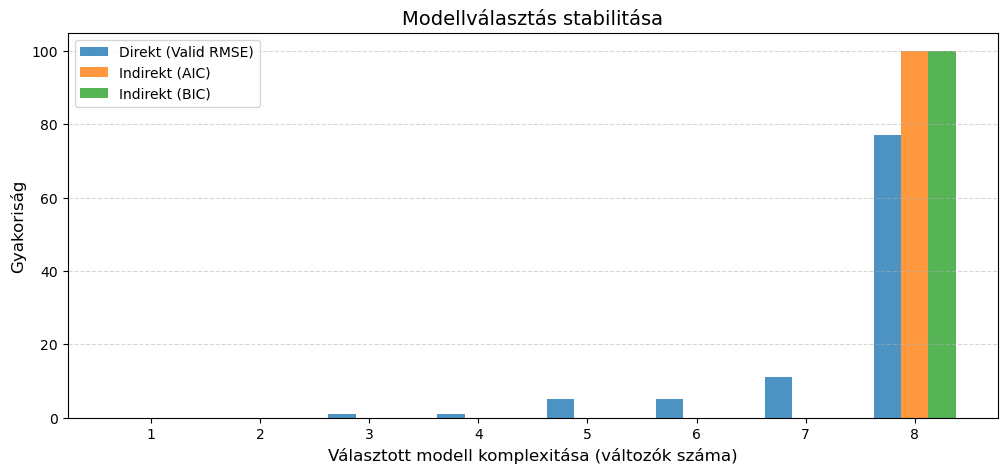

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# --- 1. ADATBEOLVASÁS ÉS SEGÉDFÜGGVÉNYEK ---
def file_open(path):
    with open(path, encoding="UTF-8") as f:
        x = f.readlines()
    del x[0]
    return x

def yesno_dummy(v):
    return 1 if v == "yes" else 0

def data_management(raw_data):
    y, x1, x2, x3, x4, x5, x6, x7, x8 = [], [], [], [], [], [], [], [], []
    for line in raw_data:
        variables = line.strip().split(",")
        y.append(int(variables[0]))
        x1.append(int(variables[1]))
        x2.append(int(variables[2]))
        x3.append(int(variables[3]))
        x4.append(int(variables[4]))
        x5.append(yesno_dummy(variables[5]))
        x6.append(yesno_dummy(variables[6]))
        x7.append(yesno_dummy(variables[7]))
        x8.append(int(variables[10]))
    return y, x1, x2, x3, x4, x5, x6, x7, x8

def rmse(actual, predicted):
    return float(np.sqrt(np.mean((np.asarray(actual) - np.asarray(predicted))**2)))

def fit_multivar(data_df, var_list):
    X = data_df[var_list].values
    X_with_const = np.hstack([np.ones((X.shape[0], 1)), X])
    y = data_df["y"].values
    beta, *_ = np.linalg.lstsq(X_with_const, y, rcond=None)
    return {"beta": beta, "variables": var_list}

def predict_multivar(model, x_new_df):
    var_list = model["variables"]
    X = x_new_df[var_list].values
    X_with_const = np.hstack([np.ones((X.shape[0], 1)), X])
    return X_with_const @ model["beta"]

def fit_ols_ic(df, cols):
    X = sm.add_constant(df[cols].values)
    y = df["y"].values
    res = sm.OLS(y, X).fit()
    return res.aic, res.bic

# Adatok betöltése
raw_data = file_open("Housing.csv")
y, x1, x2, x3, x4, x5, x6, x7, x8 = data_management(raw_data)
df = pd.DataFrame({'y': y, 'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4, 
                   'x5': x5, 'x6': x6, 'x7': x7, 'x8': x8})

all_vars = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
model_definitions = [all_vars[:i] for i in range(1, 9)]

# --- 2. SZIMULÁCIÓ (100x ismétlés) ---
n_sims = 100
rng = np.random.default_rng(42)

# Tárolók az eredményeknek
results_rmse = {
    "Direkt (Valid RMSE)": [],
    "Indirekt (AIC)": [],
    "Indirekt (BIC)": [],
    "LASSO CV": []
}

results_selection = {
    "Direkt (Valid RMSE)": [],
    "Indirekt (AIC)": [],
    "Indirekt (BIC)": [],
    "LASSO CV (Vars)": []
}

print(f"Szimuláció futtatása {n_sims} ismétléssel az eloszlás ábrákhoz...")

for s in range(n_sims):
    # Split
    idx = np.arange(len(df))
    rng.shuffle(idx)
    work = df.iloc[idx[:int(0.8*len(df))]].reset_index(drop=True)
    test = df.iloc[idx[int(0.8*len(df)):]].reset_index(drop=True)
    
    idx2 = np.arange(len(work))
    rng.shuffle(idx2)
    trn = work.iloc[idx2[:int(0.8*len(work))]].reset_index(drop=True)
    val = work.iloc[idx2[int(0.8*len(work)):]].reset_index(drop=True)
    
    # 1-3. Módszerek (Direkt, AIC, BIC)
    val_rmses = []
    aics = []
    bics = []
    
    for j, cols in enumerate(model_definitions):
        # Direkt
        mod = fit_multivar(trn, cols)
        pred_v = predict_multivar(mod, val)
        val_rmses.append(rmse(val["y"], pred_v))
        
        # IC
        aic, bic = fit_ols_ic(work, cols)
        aics.append(aic)
        bics.append(bic)
        
    # Kiválasztás és Kiértékelés
    
    # Direkt
    best_idx = np.argmin(val_rmses)
    mod_fin = fit_multivar(work, model_definitions[best_idx])
    results_rmse["Direkt (Valid RMSE)"].append(rmse(test["y"], predict_multivar(mod_fin, test)))
    results_selection["Direkt (Valid RMSE)"].append(best_idx + 1)
    
    # AIC
    best_idx = np.argmin(aics)
    mod_fin = fit_multivar(work, model_definitions[best_idx])
    results_rmse["Indirekt (AIC)"].append(rmse(test["y"], predict_multivar(mod_fin, test)))
    results_selection["Indirekt (AIC)"].append(best_idx + 1)

    # BIC
    best_idx = np.argmin(bics)
    mod_fin = fit_multivar(work, model_definitions[best_idx])
    results_rmse["Indirekt (BIC)"].append(rmse(test["y"], predict_multivar(mod_fin, test)))
    results_selection["Indirekt (BIC)"].append(best_idx + 1)
    
    # 4. LASSO (JAVÍTVA: Külön scaler X-nek és y-nak)
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    
    X_work_sc = scaler_X.fit_transform(work[all_vars])
    y_work_sc = scaler_y.fit_transform(work[['y']]).flatten()
    
    X_test_sc = scaler_X.transform(test[all_vars])
    
    lcv = LassoCV(cv=5, random_state=int(rng.integers(0,1e6))).fit(X_work_sc, y_work_sc)
    pred_sc = lcv.predict(X_test_sc)
    pred = scaler_y.inverse_transform(pred_sc.reshape(-1,1)).flatten()
    
    results_rmse["LASSO CV"].append(rmse(test["y"], pred))
    
    # Hány változót tartott meg?
    n_vars = np.sum(np.abs(lcv.coef_) > 1e-10)
    results_selection["LASSO CV (Vars)"].append(n_vars)

# DataFrame konverzió
df_rmse_res = pd.DataFrame(results_rmse)
df_sel_res = pd.DataFrame(results_selection)

# --- 3. ÁBRÁZOLÁS ---

# 1. ÁBRA: Holdout RMSE Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_rmse_res, palette="Set2")
plt.title('Holdout RMSE eloszlása 100 szimuláció alapján', fontsize=14)
plt.ylabel('RMSE (Holdout)', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. ÁBRA: Kiválasztott modellek eloszlása
methods_to_plot = ["Direkt (Valid RMSE)", "Indirekt (AIC)", "Indirekt (BIC)"]
plt.figure(figsize=(12, 5))

width = 0.25
x = np.arange(1, 9) 

for i, method in enumerate(methods_to_plot):
    counts = df_sel_res[method].value_counts().reindex(x, fill_value=0)
    plt.bar(x + (i-1)*width, counts, width=width, label=method, alpha=0.8)

plt.title('Modellválasztás stabilitása', fontsize=14)
plt.xlabel('Választott modell komplexitása (változók száma)', fontsize=12)
plt.ylabel('Gyakoriság', fontsize=12)
plt.xticks(x)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()